In [1]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve
from AngioMorphPCA.io import Get_simple_vtk
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from procrustes import rotational
from tqdm import tqdm

# all_L2_table = np.load("../all_L2_table.npy")
# print (all_L2_table.shape)
# interpolation_nums = np.array([50, 100, 200, 400, 800, 1600])
# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(111)
# ax.plot(1/interpolation_nums, np.mean(all_L2_table, axis=1), marker='o', color='b')
# ax.scatter(1/interpolation_nums, np.min(all_L2_table, axis=1), marker='v', color='r')
# ax.scatter(1/interpolation_nums, np.max(all_L2_table, axis=1), marker='^', color='g')
# ax.set_xticks(1/interpolation_nums)
# ax.set_xticklabels(interpolation_nums, rotation=60)
# for i in range(len(interpolation_nums)):
#     # ax.axvline(x=1/i,  linestyle='--', alpha=0.5, color='blue')
#     ax.annotate(str(interpolation_nums[i]), (1/interpolation_nums[i], np.mean(all_L2_table, axis=1)[i]))
# # plt.savefig("L2_distance_mean.png")
# # plt.close()
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel("Curve Resolution")
# ax.set_ylabel("L2 Distance")
# plt.grid()
# plt.show()
def makeVtkFile(savePath, coords, scalarAttributes):
    v = open(savePath, "w+")
    v.write("# vtk DataFile Version 2.0\nVessel Segment\nASCII\nDATASET POLYDATA\nPOINTS {} float\n".format(len(coords)))
    for i in range(len(coords)):
        v.write("{} {} {}\n".format(coords[i,0], coords[i,1], coords[i,2]))

    v.write("LINES {} {}\n".format(1, len(coords)+1))
    v.write("{}".format(len(coords)))
    for i in range(len(coords)):
        v.write(" {}".format(i))
    v.write("\n")

    ####################################
    #        scalar Attributes         #
    ####################################

    if len(scalarAttributes) > 0:
        v.write("POINT_DATA {}\n".format(len(coords)))
        for i in range(len(scalarAttributes)):
            v.write("SCALARS {} {}\n".format(scalarAttributes[i][0], scalarAttributes[i][1]))
            v.write("LOOKUP_TABLE default\n")
            for j in range(len(coords)):
                    v.write("{}\n".format(scalarAttributes[i][2][j]))

    v.close()

(104, 100, 3)


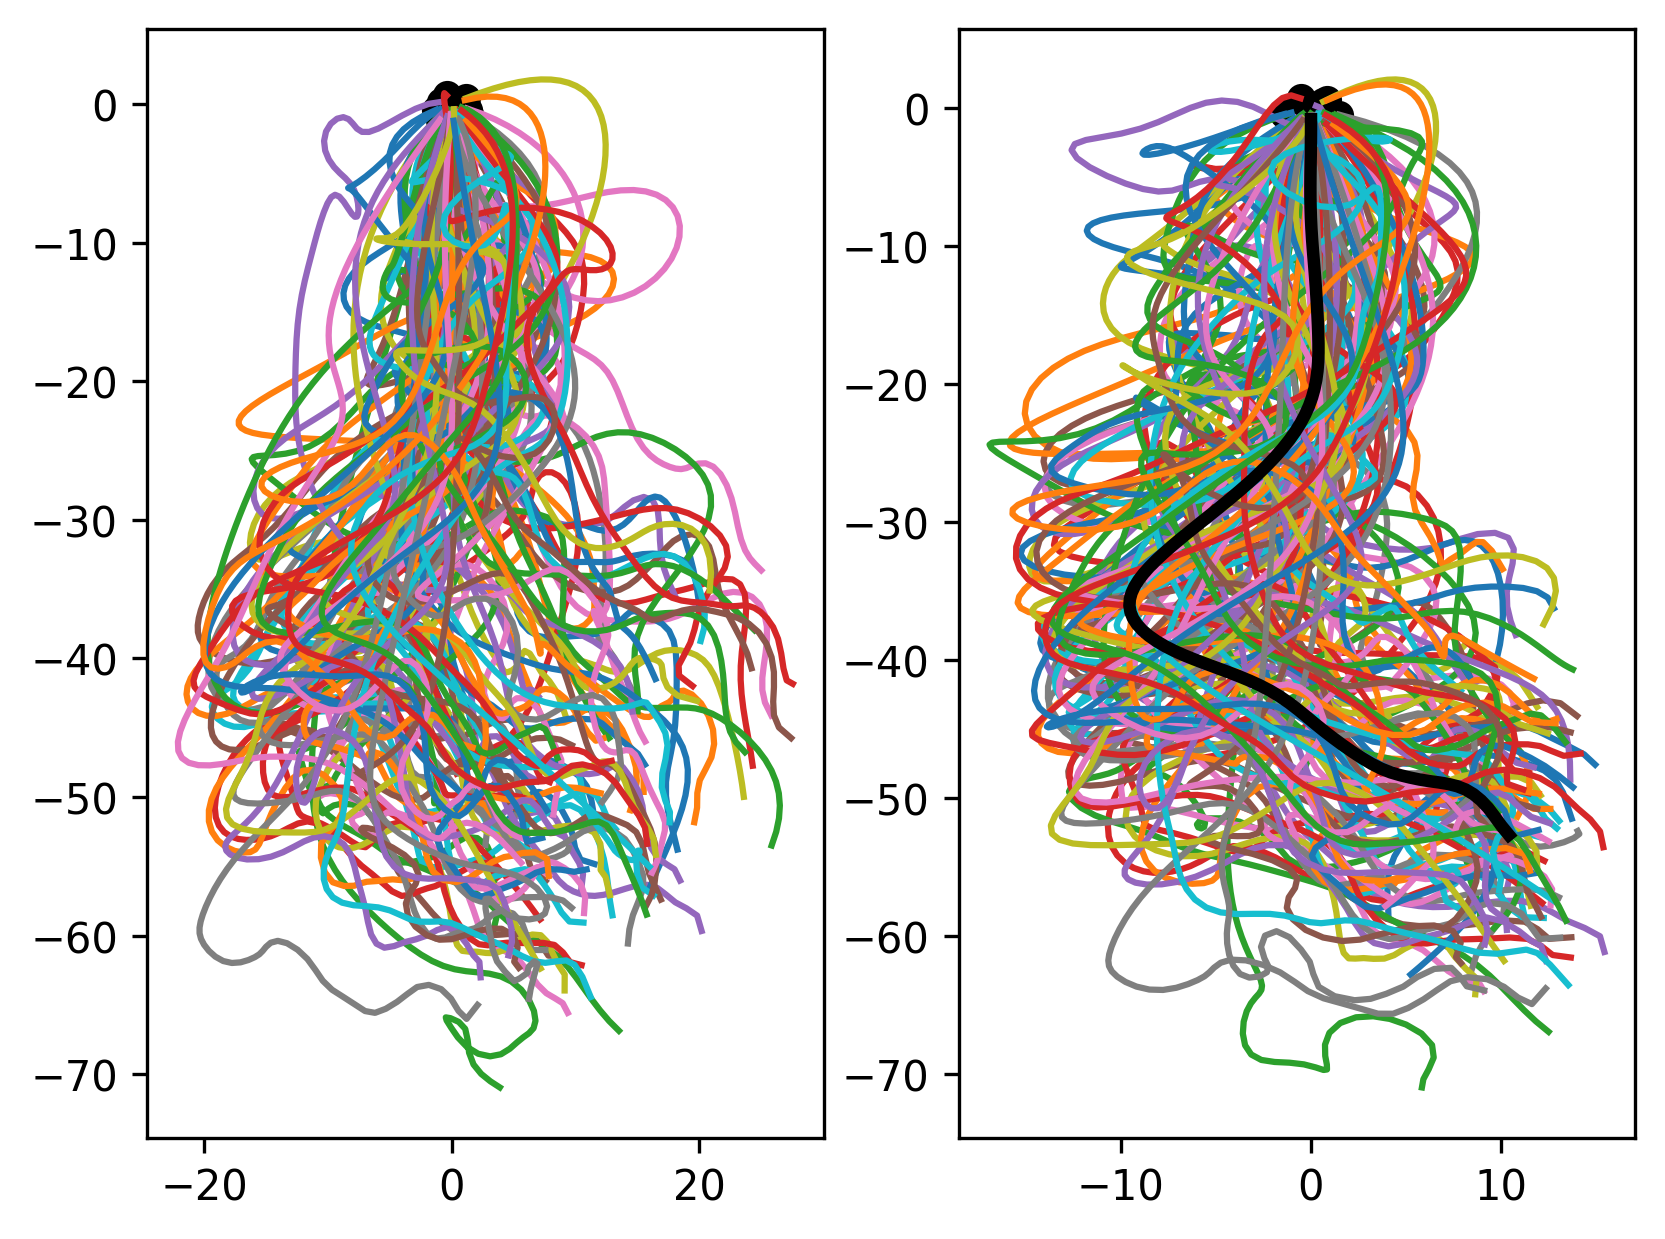

In [3]:
min_reparam = np.load("../save_orbits/24-04-01-12-44-52/min_reparam.npy")

from procrustes import generalized

min_reparamm, _ = generalized(min_reparam)

print (min_reparam.shape)
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
reconstructed_curve = []
for i in range(len(min_reparam)):
    r_curve = reconstruct_curve_from_srvf(min_reparam[i],np.array([0,0,0]))
    reconstructed_curve.append(r_curve)
    ax1.plot(r_curve[:,2], r_curve[:,1])
    ax1.scatter(r_curve[0,2], r_curve[0,1], color='k')


reconstructed_curve, _ = generalized(reconstructed_curve)
for i in range(len(min_reparam)):
    ax2.plot(reconstructed_curve[i][:,2], reconstructed_curve[i][:,1])
    ax2.scatter(reconstructed_curve[i][0,2], reconstructed_curve[i][0,1], color='k')

    makeVtkFile("../save_orbits/24-04-01-12-44-52/{}.vtk".format(i), reconstructed_curve[i], [])



average_curve = np.mean(reconstructed_curve, axis=0)
ax2.plot(average_curve[:,2], average_curve[:,1], color='black', linewidth=3)
reconstructed_curve = np.array(reconstructed_curve)

makeVtkFile("../save_orbits/24-04-01-12-44-52/average_curve.vtk", average_curve, [])

C:\Users\cheno\AppData\Local\Temp\ipykernel_21124\1206170481.py:24: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
C:\Users\cheno\AppData\Local\Temp\ipykernel_21124\1206170481.py:27: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


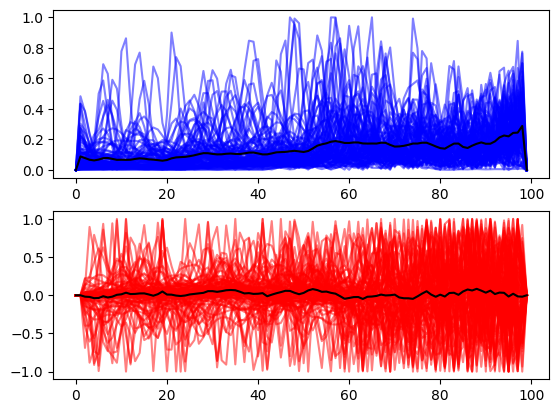

In [4]:
def compute_curvature_and_torsion(curve):

    # calculate first, second, and third derivatives using finite differences
    r_prime = np.diff(curve, axis=0)
    r_double_prime = np.diff(r_prime, axis=0)
    r_triple_prime = np.diff(r_double_prime, axis=0)

    # Pad derivatives to align array sizes
    r_prime = np.vstack((r_prime, np.zeros((1, 3))))
    r_double_prime = np.vstack((np.zeros((1, 3)), r_double_prime, np.zeros((1, 3))))
    r_triple_prime = np.vstack((np.zeros((2, 3)), r_triple_prime, np.zeros((2, 3))))

    # Ensure that r_prime, r_double_prime, and r_triple_prime have the same shape
    min_length = min(len(r_prime), len(r_double_prime), len(r_triple_prime))
    r_prime = r_prime[:min_length]
    r_double_prime = r_double_prime[:min_length]
    r_triple_prime = r_triple_prime[:min_length]

    cross_product = np.cross(r_prime, r_double_prime)
    cross_norm = np.linalg.norm(cross_product, axis=1)
    r_prime_norm = np.linalg.norm(r_prime, axis=1)

    epsilon = 1e-7
    curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)

    torsion_numerator = np.einsum('ij,ij->i', r_prime, np.cross(r_double_prime, r_triple_prime))
    torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)

    # Apply non-linear transformation
    curvature = np.tanh(curvature)
    torsion = np.tanh(torsion)


    # Create the interpolator functions for curvature and torsion
    # We are using 'linear' interpolation and 'extrapolate' to allow extension beyond the original range
    interp_curvature = interp1d(np.arange(len(curvature)), curvature, kind='linear', fill_value="extrapolate")
    interp_torsion = interp1d(np.arange(len(torsion)), torsion, kind='linear', fill_value="extrapolate")

    # Use the interpolator functions to extend the arrays to the original curve length
    interpolated_curvature = interp_curvature(np.arange(len(curve)))
    interpolated_torsion = interp_torsion(np.arange(len(curve)))

    return interpolated_curvature, interpolated_torsion

curvatures = []
torsions = []
fig = plt.figure(dpi=100)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
for i in range(len(reconstructed_curve)):
    curvature,torsion = compute_curvature_and_torsion(reconstructed_curve[i])
    curvatures.append(curvature)
    torsions.append(torsion)
    ax1.plot(curvature, label='curvature', color='blue', alpha=0.5)
    ax2.plot(torsion, label='torsion', color='red', alpha=0.5)
# plt.legend()
ax1.plot(np.mean(curvatures, axis=0), label='curvature', color='black', alpha=1)
ax2.plot(np.mean(torsions, axis=0), label='torsion', color='black', alpha=1)
plt.show()
    